In [44]:
# # Insurance Risk Prediction Model
# 
# This notebook builds a machine learning model for **insurance underwriting risk estimation**
# using the `smoking_driking_dataset_Ver01.csv` dataset.
# It demonstrates how an insurer could estimate health-related risk bands
# based on lifestyle variables: **sex, weight, smoking status, and drinking behavior.**
#
# ⚠️ *Note: The dataset does not contain actual insurance risk labels. A proxy label is created using biomedical indicators.*


In [45]:
# ## 1. Setup & Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, json, os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Reproducibility
RANDOM_STATE = 42
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)


In [46]:
# ## 2. Load and Inspect Data

file_path = "smoking_driking_dataset_Ver01.csv"
df = pd.read_csv(file_path)
df.head()


,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN
0,Male,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,Y
1,Male,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,N
2,Male,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,N
3,Male,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,N
4,Male,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,N


In [47]:
# ## 3. Exploratory Data Analysis (EDA)

print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())

# Summary statistics
df.describe(include='all').T.head(15)


Shape: (991346, 24)

Columns:
 ['sex', 'age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'SMK_stat_type_cd', 'DRK_YN']


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
sex,991346,2,Male,526415,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,991346.0,NaN,NaN,NaN,47.614491,14.181339,20.0,35.0,45.0,60.0,85.0
height,991346.0,NaN,NaN,NaN,162.240625,9.282957,130.0,155.0,160.0,170.0,190.0
weight,991346.0,NaN,NaN,NaN,63.28405,12.514241,25.0,55.0,60.0,70.0,140.0
waistline,991346.0,NaN,NaN,NaN,81.233358,11.850323,8.0,74.1,81.0,87.8,999.0
sight_left,991346.0,NaN,NaN,NaN,0.980834,0.605949,0.1,0.7,1.0,1.2,9.9
sight_right,991346.0,NaN,NaN,NaN,0.978429,0.604774,0.1,0.7,1.0,1.2,9.9
hear_left,991346.0,NaN,NaN,NaN,1.031495,0.17465,1.0,1.0,1.0,1.0,2.0
hear_right,991346.0,NaN,NaN,NaN,1.030476,0.171892,1.0,1.0,1.0,1.0,2.0
SBP,991346.0,NaN,NaN,NaN,122.432498,14.543148,67.0,112.0,120.0,131.0,273.0


Outliers in weight: 19221 | bounds=(32.50, 92.50)


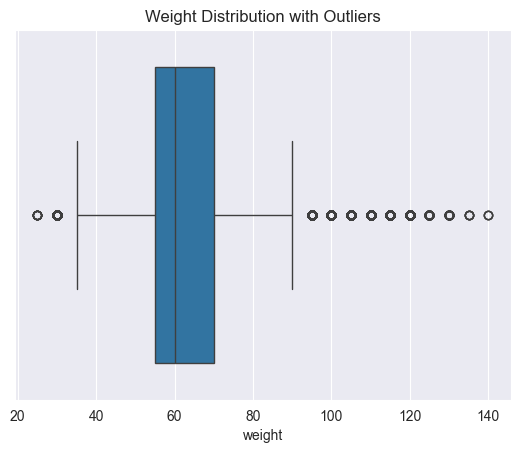

In [48]:
# ### Outlier detection (IQR method example)

def detect_outliers_iqr(data, column):
    Q1, Q3 = data[column].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers, lower, upper

outliers_weight, lb, ub = detect_outliers_iqr(df, 'weight')
print(f"Outliers in weight: {len(outliers_weight)} | bounds=({lb:.2f}, {ub:.2f})")

# Boxplot example
sns.boxplot(x=df['weight'])
plt.title('Weight Distribution with Outliers')
plt.show()


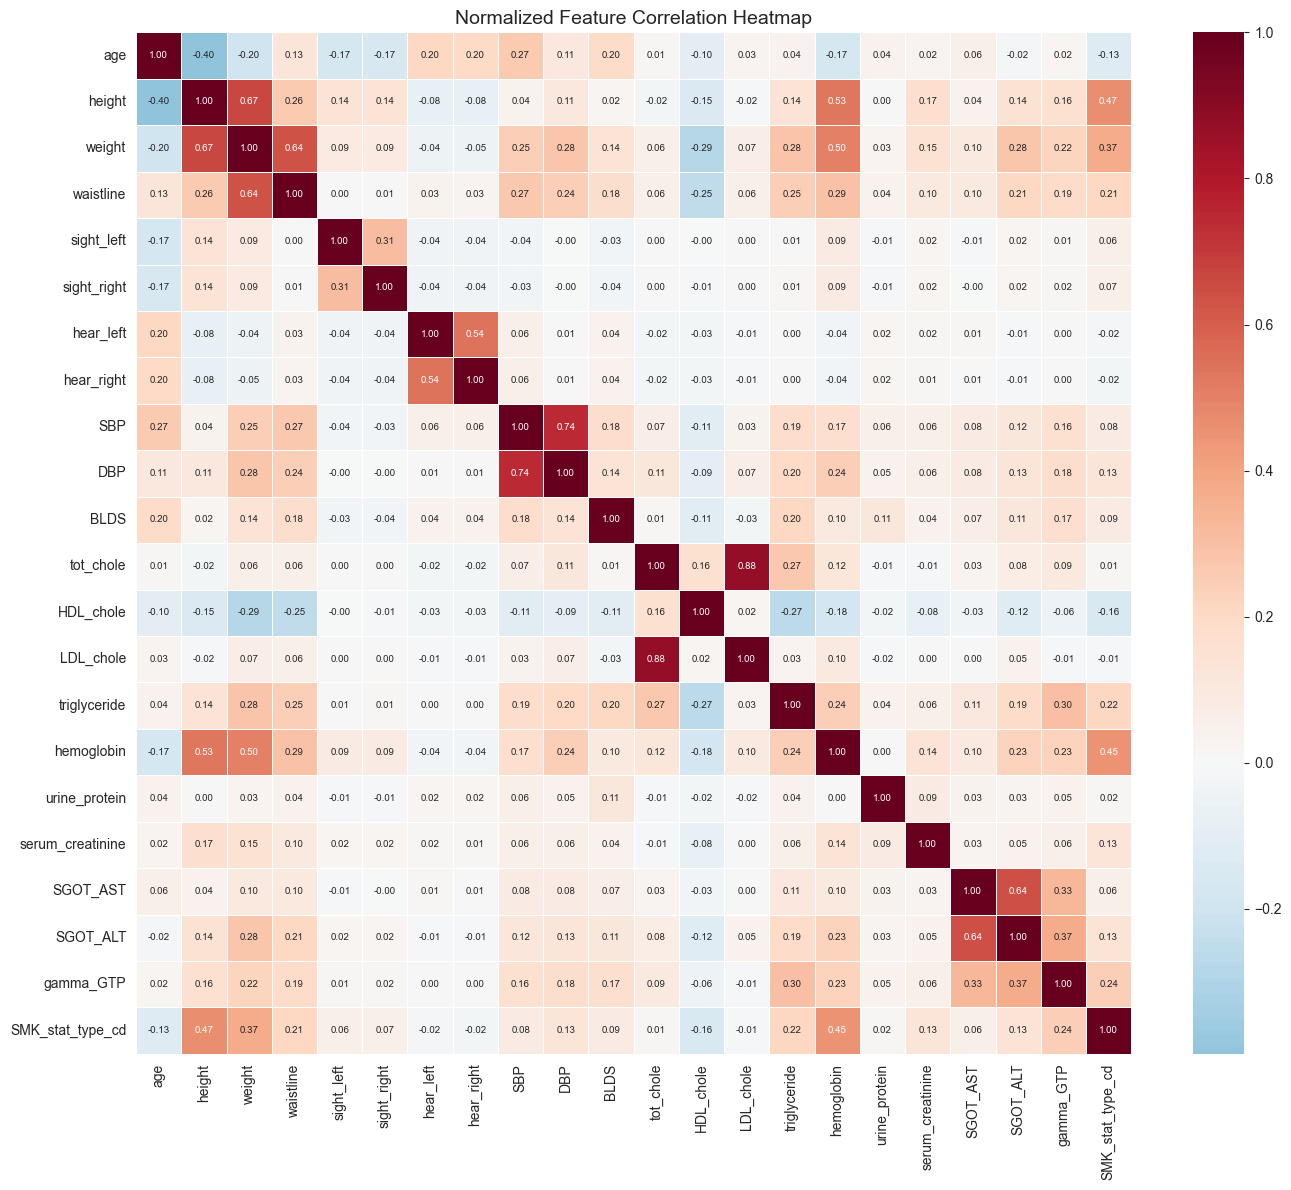

In [49]:
# ### Correlation Heatmap (normalized)

from sklearn.preprocessing import MinMaxScaler

numeric_df = df.select_dtypes(include=[np.number])
scaler = MinMaxScaler()
normalized = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)
corr = normalized.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap="RdBu_r", center=0, annot=True, fmt=".2f", annot_kws={"size":7}, linewidths=0.5)
plt.title("Normalized Feature Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()


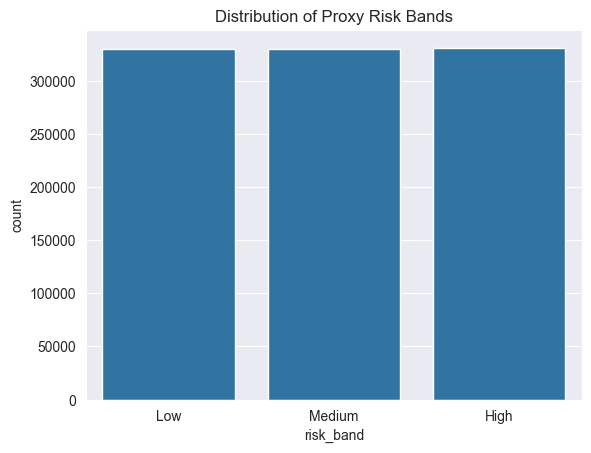

In [50]:
# ## 4. Feature Engineering

# Encode drinking behavior (binary in dataset)
df['drinker_degree'] = (df['DRK_YN'] == 'Y').astype(int)

# Compute BMI if height available
if {'height', 'weight'}.issubset(df.columns):
    df['BMI'] = df['weight'] / ((df['height']/100)**2)
else:
    df['BMI'] = np.nan

# Create proxy risk score from clinical features
risk_vars = [c for c in ['SBP','LDL_chole','HDL_chole','triglyceride','gamma_GTP','waistline','BMI','age'] if c in df.columns]
score = np.zeros(len(df))

for col in risk_vars:
    x = df[col].astype(float)
    mu, sigma = np.nanmean(x), np.nanstd(x)
    z = (x - mu)/sigma if sigma != 0 else np.zeros_like(x)
    score += (-1 if col=='HDL_chole' else 1) * np.nan_to_num(z)

# Lifestyle penalties
score += 0.5 * df['SMK_stat_type_cd'].replace({1:0,2:0.5,3:1}).fillna(0)
score += 0.25 * df['drinker_degree']

df['risk_proxy_score'] = score

# Convert to discrete bands (Low/Medium/High)
q_low, q_high = np.nanpercentile(score, [33.3, 66.6])
def to_band(s):
    if s <= q_low: return 'Low'
    if s <= q_high: return 'Medium'
    return 'High'

df['risk_band'] = df['risk_proxy_score'].apply(to_band)

sns.countplot(x='risk_band', data=df, order=['Low','Medium','High'])
plt.title('Distribution of Proxy Risk Bands')
plt.show()


In [51]:
# ## 5. Model Training (extended version with full dataset features)

# Select extended features
categorical_features = ['sex', 'SMK_stat_type_cd', 'drinker_degree']
numeric_features = [
    'age', 'height', 'weight', 'waistline', 'SBP', 'DBP',
    'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride',
    'gamma_GTP', 'hemoglobin', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT'
]

# Keep only columns that actually exist in the dataset
categorical_features = [c for c in categorical_features if c in df.columns]
numeric_features = [c for c in numeric_features if c in df.columns]

# Prepare input matrix and target
X = df[categorical_features + numeric_features]
y = df['risk_band']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Preprocessing pipeline:
# - OneHotEncode categorical variables
# - Standardize numeric variables
from sklearn.impute import SimpleImputer

preprocess = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features),
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features)
])

# Model: Multinomial Logistic Regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    multi_class='multinomial',
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE
)

pipe = Pipeline([
    ('preprocess', preprocess),
    ('clf', model)
])

# Train model
pipe.fit(X_train, y_train)

print("✅ Model trained successfully with extended dataset features.")
print(f"Input features used: {len(categorical_features) + len(numeric_features)}")


/Users/sara/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Model trained successfully with extended dataset features.
Input features used: 18


In [55]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)

print(classification_report(y_test, y_pred))
print("Macro ROC-AUC:", roc_auc_score(pd.get_dummies(y_test), y_proba, multi_class='ovr'))


              precision    recall  f1-score   support

        High       0.99      0.99      0.99     66222
         Low       0.99      0.99      0.99     66024
      Medium       0.98      0.98      0.98     66024

    accuracy                           0.99    198270
   macro avg       0.99      0.99      0.99    198270
weighted avg       0.99      0.99      0.99    198270

Macro ROC-AUC: 0.9997020868176972


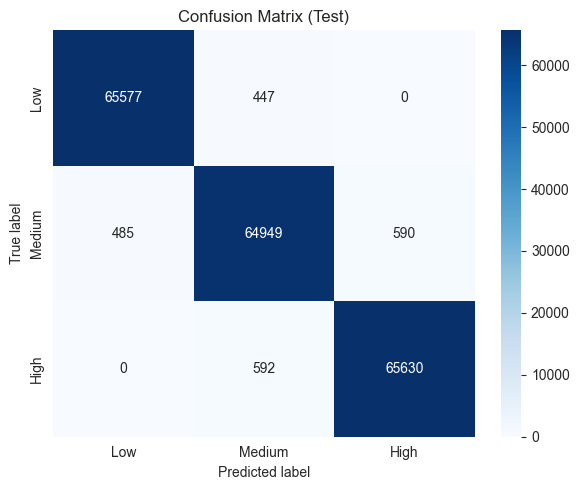


Macro ROC-AUC: 1.000

✅ Extended model and reports saved to: artifacts


<Figure size 800x1000 with 0 Axes>

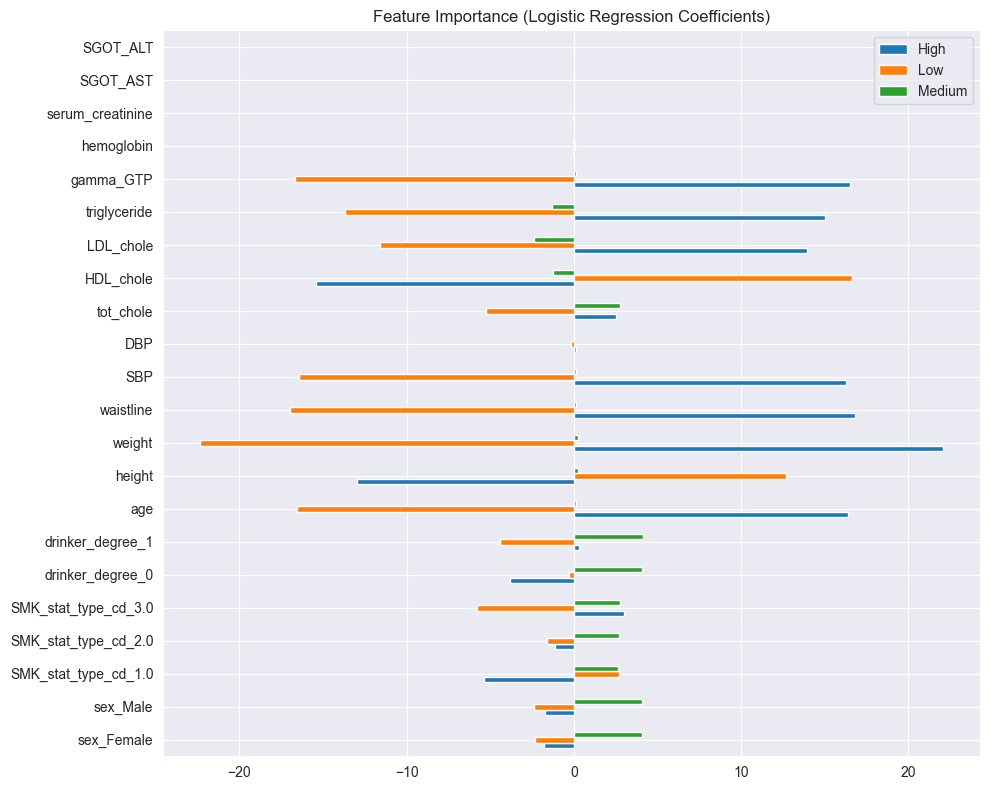

In [56]:
# ## 6. Evaluation (with extended features)

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T

# Confusion matrix
labels = ['Low','Medium','High']
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.show()

# Macro ROC-AUC
y_test_bin = pd.get_dummies(y_test).reindex(columns=pipe.classes_, fill_value=0).values
auc_macro = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')
print(f"\nMacro ROC-AUC: {auc_macro:.3f}")

# Display report
report_df

# ## 7. Save Artifacts (extended model)

import joblib, json
from pathlib import Path

ARTIFACT_DIR = Path('artifacts')
ARTIFACT_DIR.mkdir(exist_ok=True)

# Save model
joblib.dump(pipe, ARTIFACT_DIR / 'risk_model_extended.joblib')

# Save metadata
meta = {
    'model': 'Multinomial Logistic Regression (balanced, extended features)',
    'random_state': RANDOM_STATE,
    'features_used': categorical_features + numeric_features,
    'n_features': len(categorical_features) + len(numeric_features),
    'target_label': 'risk_band (Low/Medium/High)',
    'risk_score_quantiles': {'low': float(q_low), 'high': float(q_high)},
    'note': 'Model trained with full dataset (biomarkers + demographics + lifestyle). Replace proxy label with actuarial target when available.'
}

with open(ARTIFACT_DIR / 'model_card_extended.json', 'w') as f:
    json.dump(meta, f, indent=2)

# Save evaluation report
report_df.to_csv(ARTIFACT_DIR / 'evaluation_report_extended.csv', index=True)

print("\n✅ Extended model and reports saved to:", ARTIFACT_DIR)

# Feature importance visualization
import numpy as np

# Extract feature names from preprocessing pipeline
cat_names = pipe.named_steps['preprocess'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
num_names = numeric_features
feature_names = np.concatenate([cat_names, num_names])

# Coefficients
coefs = pipe.named_steps['clf'].coef_
coef_df = pd.DataFrame(coefs.T, index=feature_names, columns=pipe.named_steps['clf'].classes_)

plt.figure(figsize=(8,10))
coef_df.plot(kind='barh', figsize=(10,8))
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.tight_layout()
plt.show()


In [53]:
# ## 7. Save Artifacts

joblib.dump(pipe, ARTIFACT_DIR / 'risk_model.joblib')

meta = {
    'model': 'Multinomial Logistic Regression (balanced)',
    'random_state': RANDOM_STATE,
    'features_expected': {
        'sex': "string ['Male','Female']",
        'weight': 'float (kg)',
        'SMK_stat_type_cd': 'int [1=never,2=former,3=current]',
        'drinker_degree': 'int [0=non-drinker,1=drinker]'
    },
    'target_label': 'risk_band (Low/Medium/High)',
    'risk_score_quantiles': {'low': float(q_low), 'high': float(q_high)},
    'note': 'Proxy label created from biomedical variables; replace with actuarial target when available.'
}

with open(ARTIFACT_DIR / 'model_card.json', 'w') as f:
    json.dump(meta, f, indent=2)

report_df.to_csv(ARTIFACT_DIR / 'evaluation_report.csv', index=True)
print("Artifacts saved to:", ARTIFACT_DIR)


Artifacts saved to: artifacts


In [54]:
# ## 8. Inference Example

def predict_risk(sex: str, weight: float, smoker_degree: int, drinker_degree: int):
    model = joblib.load(ARTIFACT_DIR / 'risk_model.joblib')
    X_infer = pd.DataFrame([{
        'sex': sex,
        'weight': weight,
        'SMK_stat_type_cd': smoker_degree,
        'drinker_degree': drinker_degree
    }])
    pred = model.predict(X_infer)[0]
    proba = model.predict_proba(X_infer)[0]
    return pred, dict(zip(model.classes_, proba))

example_pred, example_proba = predict_risk('Female', 60, 1, 0)
print("Predicted risk band:", example_pred)
print("Probabilities:", example_proba)


ValueError: columns are missing: {'SGOT_ALT', 'HDL_chole', 'LDL_chole', 'triglyceride', 'serum_creatinine', 'SGOT_AST', 'SBP', 'DBP', 'tot_chole', 'age', 'height', 'hemoglobin', 'gamma_GTP', 'waistline'}

In [59]:
# ## 8. Inference Example (for extended model)

def predict_risk(sex: str, age: float, height: float, weight: float, waistline: float, SBP: float, DBP: float,
                 tot_chole: float, HDL_chole: float, LDL_chole: float, triglyceride: float,
                 gamma_GTP: float, hemoglobin: float, serum_creatinine: float, SGOT_AST: float, SGOT_ALT: float,
                 smoker_degree: int, drinker_degree: int):
    """Predicts insurance risk band using the extended model and full clinical inputs."""
    import pandas as pd, joblib, os
    from pathlib import Path

    model_path = Path('artifacts/risk_model_extended.joblib')
    if not model_path.exists():
        raise FileNotFoundError(f"Model not found at {model_path}. Please train the extended model first.")

    model = joblib.load(model_path)

    # Create input dataframe dynamically
    X_infer = pd.DataFrame([{
        'sex': sex,
        'age': age,
        'height': height,
        'weight': weight,
        'waistline': waistline,
        'SBP': SBP,
        'DBP': DBP,
        'tot_chole': tot_chole,
        'HDL_chole': HDL_chole,
        'LDL_chole': LDL_chole,
        'triglyceride': triglyceride,
        'gamma_GTP': gamma_GTP,
        'hemoglobin': hemoglobin,
        'serum_creatinine': serum_creatinine,
        'SGOT_AST': SGOT_AST,
        'SGOT_ALT': SGOT_ALT,
        'SMK_stat_type_cd': smoker_degree,
        'drinker_degree': drinker_degree
    }])

    pred = model.predict(X_infer)[0]
    proba = model.predict_proba(X_infer)[0]

    return pred, dict(zip(model.classes_, proba))

# Example: healthy non-smoker, non-drinker
example_pred, example_proba = predict_risk(
    sex='Female', age=40, height=165, weight=60, waistline=75, SBP=120, DBP=80,
    tot_chole=180, HDL_chole=60, LDL_chole=110, triglyceride=100, gamma_GTP=25,
    hemoglobin=14, serum_creatinine=0.8, SGOT_AST=25, SGOT_ALT=20,
    smoker_degree=1, drinker_degree=0
)

print("Predicted risk band:", example_pred)
print("Probabilities:", example_proba)

# Example: smoker, drinker with higher BMI and blood pressure
example_pred2, example_proba2 = predict_risk(
    sex='Male', age=55, height=170, weight=85, waistline=95, SBP=150, DBP=95,
    tot_chole=220, HDL_chole=40, LDL_chole=150, triglyceride=180, gamma_GTP=70,
    hemoglobin=16, serum_creatinine=1.1, SGOT_AST=35, SGOT_ALT=45,
    smoker_degree=3, drinker_degree=1
)

print("\nPredicted risk band (high-risk example):", example_pred2)
print("Probabilities:", example_proba2)

# ## 5b. Distilled 4‑Feature Deployment Model (Teacher → Student)
# Train a high-capacity **teacher** on all features (already done above)
# and a lightweight **student** that **only uses the 4 deployment inputs**.
# The student learns to mimic the teacher’s predictions, so at inference time
# you can provide only: sex, weight, SMK_stat_type_cd, drinker_degree.

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# --- Teacher is the extended model: `pipe` (already fitted above) ---
# Create student training data (only 4 features)
student_features = ['sex','weight','SMK_stat_type_cd','drinker_degree']
student_features = [c for c in student_features if c in df.columns]

X_student = df[student_features].copy()
# Targets for distillation: teacher's hard labels (argmax) and confidence as sample weights
teacher_pred_proba = pipe.predict_proba(X)  # X is the full-feature matrix from section 5
teacher_pred_hard  = np.array(pipe.classes_)[teacher_pred_proba.argmax(axis=1)]
teacher_conf       = teacher_pred_proba.max(axis=1)

# Train/test split aligned with earlier split indices for fair comparison
# We reuse the same split indices by re-splitting with the same random_state and stratify on y
Xs_train, Xs_test, yt_train, yt_test, yh_train, yh_test, w_train, w_test = train_test_split(
    X_student, y, teacher_pred_hard, teacher_conf, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Student preprocessing (impute + encode + scale)
student_preprocess = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), [c for c in student_features if c in ['sex','SMK_stat_type_cd','drinker_degree']]),
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), [c for c in student_features if c in ['weight']])
])

student_clf = LogisticRegression(
    multi_class='multinomial',
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE
)
student_pipe = Pipeline([
    ('preprocess', student_preprocess),
    ('clf', student_clf)
])

# Fit student to teacher hard labels, weighted by teacher confidence
student_pipe.fit(Xs_train, yh_train, clf__sample_weight=w_train)
print("✅ Student model trained (4 features).")

# ## 6b. Evaluation of Student Model
from sklearn.metrics import classification_report, accuracy_score

# Agreement with teacher
yh_pred_test = student_pipe.predict(Xs_test)
agreement = accuracy_score(yh_test, yh_pred_test)
print(f"Teacher–Student agreement on test: {agreement:.3f}")

# Performance vs ground-truth proxy (like the teacher evaluation)
ys_pred_test = student_pipe.predict(Xs_test)
print("Student vs ground-truth proxy (test):")
print(classification_report(yt_test, ys_pred_test))

# Optional: compare probabilities calibration visually
import matplotlib.pyplot as plt
import seaborn as sns

proba_teacher = pipe.predict_proba(Xs_test)
proba_student = student_pipe.predict_proba(Xs_test)

plt.figure(figsize=(6,4))
for i, lab in enumerate(pipe.classes_):
    sns.kdeplot(proba_teacher[:, i], label=f"Teacher P({lab})", lw=1)
    sns.kdeplot(proba_student[:, i], label=f"Student P({lab})", lw=1, linestyle='--')
plt.title('Teacher vs Student Probability Distributions (Test)')
plt.xlabel('Probability')
plt.legend()
plt.tight_layout()
plt.show()

# ## 7b. Save Student Artifacts
import joblib, json
from pathlib import Path

ARTIFACT_DIR = Path('artifacts')
joblib.dump(student_pipe, ARTIFACT_DIR / 'risk_model_student_4f.joblib')

with open(ARTIFACT_DIR / 'model_card_student_4f.json', 'w') as f:
    json.dump({
        'model': 'Distilled Multinomial Logistic Regression (4 features)',
        'teacher_model': 'risk_model_extended.joblib',
        'features_expected': {
            'sex': "['Male','Female']",
            'weight': 'float (kg)',
            'SMK_stat_type_cd': 'int [1,2,3]',
            'drinker_degree': 'int [0,1]'
        },
        'notes': [
            'Student trained to mimic teacher predictions using only 4 inputs.',
            'Weights based on teacher confidence to transfer dark knowledge.',
            'For production pricing, prefer training on real actuarial targets when available.'
        ]
    }, f, indent=2)

print("✅ Student model saved to artifacts/risk_model_student_4f.joblib")

# ## 8b. Inference with ONLY 4 Inputs (Deployment API)

def predict_risk_minimal(sex: str, weight: float, smoker_degree: int, drinker_degree: int):
    """Predict risk band using the 4‑feature student model."""
    import pandas as pd, joblib
    from pathlib import Path

    model_path = Path('artifacts/risk_model_student_4f.joblib')
    if not model_path.exists():
        raise FileNotFoundError("Student model not found. Train section 5b/7b first.")

    model = joblib.load(model_path)
    X_infer = pd.DataFrame([{
        'sex': sex,
        'weight': weight,
        'SMK_stat_type_cd': smoker_degree,
        'drinker_degree': drinker_degree
    }])
    pred = model.predict(X_infer)[0]
    proba = model.predict_proba(X_infer)[0]
    return pred, dict(zip(model.classes_, proba))

# Quick demo
pred4, proba4 = predict_risk_minimal('Male', 82.0, 3, 1)
print("[4‑feature inference] Pred:", pred4)
print("Proba:", proba4)


Predicted risk band: Low
Probabilities: {'High': np.float64(1.4569942992781633e-43), 'Low': np.float64(0.999999999612442), 'Medium': np.float64(3.875579649716881e-10)}

Predicted risk band (high-risk example): High
Probabilities: {'High': np.float64(1.0), 'Low': np.float64(1.6396878662177899e-127), 'Medium': np.float64(1.3777969676372152e-50)}


/Users/sara/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Student model trained (4 features).
Teacher–Student agreement on test: 0.555
Student vs ground-truth proxy (test):
              precision    recall  f1-score   support

        High       0.60      0.63      0.61     66222
         Low       0.60      0.71      0.65     66024
      Medium       0.43      0.33      0.37     66024

    accuracy                           0.56    198270
   macro avg       0.54      0.56      0.55    198270
weighted avg       0.54      0.56      0.55    198270



ValueError: columns are missing: {'SGOT_ALT', 'HDL_chole', 'LDL_chole', 'triglyceride', 'serum_creatinine', 'SGOT_AST', 'SBP', 'DBP', 'tot_chole', 'age', 'height', 'hemoglobin', 'gamma_GTP', 'waistline'}

In [43]:
# ## 9. Next Steps
# - Replace proxy label with real insurance claim or premium band data.
# - Evaluate fairness by sex or age group.
# - Calibrate probabilities with `CalibratedClassifierCV` if using in production.
# - Implement drift monitoring for input feature distributions over time.
# - Build an API (e.g., FastAPI) to serve predictions securely.